(lucas_asset)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Asset Pricing II: The Lucas Asset Pricing Model

```{index} single: Models; Lucas Asset Pricing
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install interpolation

## Overview

As stated in an [earlier lecture](https://python-intro.quantecon.org/markov_asset.html), an asset is a claim on a stream of prospective payments.

What is the correct price to pay for such a claim?

The elegant asset pricing model of Lucas {cite}`Lucas1978` attempts to answer this question in an equilibrium setting with risk-averse agents.

While we mentioned some consequences of Lucas' model [earlier](https://python.quantecon.org/markov_asset.html#risk-neutral-pricing), it is now time to work through the model more carefully and try to understand where the fundamental asset pricing equation comes from.

A side benefit of studying Lucas' model is that it provides a beautiful illustration of model building in general and equilibrium pricing in competitive models in particular.

Another difference to our [first asset pricing lecture](https://python-intro.quantecon.org/markov_asset.html) is that the state space and shock will be continuous rather than discrete.

Let's start with some imports:

In [2]:
import numpy as np
from interpolation import interp
from numba import njit, prange
from scipy.stats import lognorm
import matplotlib.pyplot as plt
%matplotlib inline

## The Lucas Model

```{index} single: Lucas Model
```

Lucas studied a pure exchange economy with a representative consumer (or household), where

* *Pure exchange* means that all endowments are exogenous.
* *Representative* consumer means that either
    * there is a single consumer (sometimes also referred to as a household), or
    * all consumers have identical endowments and preferences

Either way, the assumption of a representative agent means that prices adjust to eradicate desires to trade.

This makes it very easy to compute competitive equilibrium prices.

### Basic Setup

Let's review the setup.

#### Assets

```{index} single: Lucas Model; Assets
```

There is a single "productive unit" that costlessly generates a sequence of consumption goods $\{y_t\}_{t=0}^{\infty}$.

Another way to view $\{y_t\}_{t=0}^{\infty}$ is as a *consumption endowment* for this economy.

We will assume that this endowment is Markovian, following the exogenous process

$$
y_{t+1} = G(y_t, \xi_{t+1})
$$

Here $\{ \xi_t \}$ is an IID shock sequence with known distribution $\phi$ and $y_t \geq 0$.

An asset is a claim on all or part of this endowment stream.

The consumption goods $\{y_t\}_{t=0}^{\infty}$ are nonstorable, so holding assets is the only way to transfer wealth into the future.

For the purposes of intuition, it's common to think of the productive unit as a "tree" that produces fruit.

Based on this idea, a "Lucas tree" is a claim on the consumption endowment.

#### Consumers

```{index} single: Lucas Model; Consumers
```

A representative consumer ranks consumption streams $\{c_t\}$ according to the time separable utility functional

```{math}
:label: lt_uf

\mathbb{E} \sum_{t=0}^\infty \beta^t u(c_t)
```

Here

* $\beta \in (0,1)$ is a fixed discount factor.
* $u$ is a strictly increasing, strictly concave, continuously differentiable period utility function.
* $\mathbb{E}$ is a mathematical expectation.

### Pricing a Lucas Tree

```{index} single: Lucas Model; Pricing
```

What is an appropriate price for a claim on the consumption endowment?

We'll price an *ex-dividend* claim, meaning that

* the seller retains this period's dividend
* the buyer pays $p_t$ today to purchase a claim on
    * $y_{t+1}$ and
    * the right to sell the claim tomorrow at price $p_{t+1}$

Since this is a competitive model, the first step is to pin down consumer
behavior, taking prices as given.

Next, we'll impose equilibrium constraints and try to back out prices.

In the consumer problem, the consumer's control variable is the share $\pi_t$ of the claim held in each period.

Thus, the consumer problem is to maximize {eq}`lt_uf` subject to

$$
c_t + \pi_{t+1} p_t \leq \pi_t y_t + \pi_t p_t
$$

along with $c_t \geq 0$ and $0 \leq \pi_t \leq 1$ at each $t$.

The decision to hold share $\pi_t$ is actually made at time $t-1$.

But this value is inherited as a state variable at time $t$, which explains the choice of subscript.

#### The Dynamic Program

```{index} single: Lucas Model; Dynamic Program
```

We can write the consumer problem as a dynamic programming problem.

Our first observation is that prices depend on current information, and current information is really just the endowment process up until the current period.

In fact, the endowment process is Markovian, so that the only relevant
information is the current state $y \in \mathbb R_+$ (dropping the time subscript).

This leads us to guess an equilibrium where price is a function $p$ of $y$.

Remarks on the solution method

* Since this is a competitive (read: price taking) model, the consumer will take this function $p$ as given.
* In this way, we determine consumer behavior given $p$ and then use equilibrium conditions to recover $p$.
* This is the standard way to solve competitive equilibrium models.

Using the assumption that price is a given function $p$ of $y$, we write the value function and constraint as

$$
v(\pi, y) = \max_{c, \pi'}
    \left\{
        u(c) + \beta \int v(\pi', G(y, z)) \phi(dz)
    \right\}
$$

subject to

```{math}
:label: preltbe

c + \pi' p(y) \leq \pi y + \pi p(y)
```

We can invoke the fact that utility is increasing to claim equality in {eq}`preltbe` and hence eliminate the constraint, obtaining

```{math}
:label: ltbe

v(\pi, y) = \max_{\pi'}
    \left\{
        u[\pi (y + p(y)) - \pi' p(y) ] + \beta \int v(\pi', G(y, z)) \phi(dz)
    \right\}
```

The solution to this dynamic programming problem is an optimal policy expressing either $\pi'$ or $c$ as a function of the state $(\pi, y)$.

* Each one determines the other, since $c(\pi, y) = \pi (y + p(y))- \pi' (\pi, y) p(y)$

#### Next Steps

What we need to do now is determine equilibrium prices.

It seems that to obtain these, we will have to

1. Solve this two-dimensional dynamic programming problem for the optimal policy.
1. Impose equilibrium constraints.
1. Solve out for the price function $p(y)$ directly.

However, as Lucas showed, there is a related but more straightforward way to do this.

#### Equilibrium Constraints

```{index} single: Lucas Model; Equilibrium Constraints
```

Since the consumption good is not storable, in equilibrium we must have $c_t = y_t$ for all $t$.

In addition, since there is one representative consumer (alternatively, since
all consumers are identical), there should be no trade in equilibrium.

In particular, the representative consumer owns the whole tree in every period, so $\pi_t = 1$ for all $t$.

Prices must adjust to satisfy these two constraints.

#### The Equilibrium Price Function

```{index} single: Lucas Model; Equilibrium Price Function
```

Now observe that the first-order condition for {eq}`ltbe` can be written as

$$
u'(c)  p(y) = \beta \int v_1'(\pi', G(y, z)) \phi(dz)
$$

where $v'_1$ is the derivative of $v$ with respect to its first argument.

To obtain $v'_1$ we can simply differentiate the right-hand side of
{eq}`ltbe` with respect to $\pi$, yielding

$$
v'_1(\pi, y) = u'(c) (y + p(y))
$$

Next, we impose the equilibrium constraints while combining the last two
equations to get

```{math}
:label: lteeq

p(y)  = \beta \int \frac{u'[G(y, z)]}{u'(y)} [G(y, z) + p(G(y, z))]  \phi(dz)
```

In sequential rather than functional notation, we can also write this as

```{math}
:label: lteeqs

p_t = \mathbb{E}_t \left[ \beta \frac{u'(c_{t+1})}{u'(c_t)} ( y_{t+1} + p_{t+1} ) \right]
```

This is the famous consumption-based asset pricing equation.

Before discussing it further we want to solve out for prices.

### Solving the Model

```{index} single: Lucas Model; Solving
```

Equation {eq}`lteeq` is a *functional equation* in the unknown function $p$.

The solution is an equilibrium price function $p^*$.

Let's look at how to obtain it.

#### Setting up the Problem

Instead of solving for it directly we'll follow Lucas' indirect approach, first setting

```{math}
:label: ltffp

f(y) := u'(y) p(y)
```

so that {eq}`lteeq` becomes

```{math}
:label: lteeq2

f(y) = h(y) + \beta \int f[G(y, z)] \phi(dz)
```

Here $h(y) := \beta \int u'[G(y, z)] G(y, z)  \phi(dz)$ is a function that
depends only on the primitives.

Equation {eq}`lteeq2` is a functional equation in $f$.

The plan is to solve out for $f$ and convert back to $p$ via {eq}`ltffp`.

To solve {eq}`lteeq2` we'll use a standard method: convert it to a fixed point problem.

First, we introduce the operator $T$ mapping $f$ into $Tf$ as defined by

```{math}
:label: lteeqT

(Tf)(y) = h(y) + \beta \int f[G(y, z)] \phi(dz)
```

In what follows, we refer to $T$ as the Lucas operator.

The reason we do this is that a solution to {eq}`lteeq2` now corresponds to a
function $f^*$ satisfying $(Tf^*)(y) = f^*(y)$ for all $y$.

In other words, a solution is a *fixed point* of $T$.

This means that we can use fixed point theory to obtain and compute the solution.

#### A Little Fixed Point Theory

```{index} single: Fixed Point Theory
```

Let $cb\mathbb{R}_+$ be the set of continuous bounded functions $f \colon \mathbb{R}_+ \to \mathbb{R}_+$.

We now show that

1. $T$ has exactly one fixed point $f^*$ in $cb\mathbb{R}_+$.
1. For any $f \in cb\mathbb{R}_+$, the sequence $T^k f$ converges
   uniformly to $f^*$.

```{note}
If you find the mathematics heavy going you can take 1--2 as given and skip to the {ref}`next section <lt_comp_eg>`
```

Recall the [Banach contraction mapping theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem).

It tells us that the previous statements will be true if we can find an
$\alpha < 1$ such that

```{math}
:label: ltbc

\| Tf - Tg \| \leq \alpha \| f - g \|,
\qquad \forall \, f, g \in cb\mathbb{R}_+
```

Here $\|h\| := \sup_{x \in \mathbb{R}_+} |h(x)|$.

To see that {eq}`ltbc` is valid, pick any $f,g \in cb\mathbb{R}_+$ and any $y \in \mathbb{R}_+$.

Observe that, since integrals get larger when absolute values are moved to the
inside,

$$
\begin{aligned}
    |Tf(y) - Tg(y)|
    & = \left| \beta \int f[G(y, z)] \phi(dz)
        -\beta \int g[G(y, z)] \phi(dz) \right|
    \\
    & \leq \beta \int \left| f[G(y, z)] -  g[G(y, z)] \right| \phi(dz)
    \\
    & \leq \beta \int \| f -  g \| \phi(dz)
    \\
    & = \beta  \| f -  g \|
\end{aligned}
$$

Since the right-hand side is an upper bound, taking the sup over all $y$
on the left-hand side gives {eq}`ltbc` with $\alpha := \beta$.

(lt_comp_eg)=
### Computation -- An Example

```{index} single: Lucas Model; Computation
```

The preceding discussion tells that we can compute $f^*$ by picking any arbitrary $f \in cb\mathbb{R}_+$ and then iterating with $T$.

The equilibrium price function $p^*$ can then be recovered by $p^*(y) = f^*(y) / u'(y)$.

Let's try this when $\ln y_{t+1} = \alpha \ln y_t + \sigma \epsilon_{t+1}$ where $\{\epsilon_t\}$ is IID and standard normal.

Utility will take the isoelastic form $u(c) = c^{1-\gamma}/(1-\gamma)$, where $\gamma > 0$ is the coefficient of relative risk aversion.

We will set up a `LucasTree` class to hold parameters of the model

In [3]:
class LucasTree:
    """
    Class to store parameters of the Lucas tree model.

    """

    def __init__(self,
                 γ=2,            # CRRA utility parameter
                 β=0.95,         # Discount factor
                 α=0.90,         # Correlation coefficient
                 σ=0.1,          # Volatility coefficient
                 grid_size=100):

        self.γ, self.β, self.α, self.σ = γ, β, α, σ

        # Set the grid interval to contain most of the mass of the
        # stationary distribution of the consumption endowment
        ssd = self.σ / np.sqrt(1 - self.α**2)
        grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        self.grid_size = grid_size

        # Set up distribution for shocks
        self.ϕ = lognorm(σ)
        self.draws = self.ϕ.rvs(500)

        self.h = np.empty(self.grid_size)
        for i, y in enumerate(self.grid):
            self.h[i] = β * np.mean((y**α * self.draws)**(1 - γ))

The following function takes an instance of the `LucasTree` and generates a
jitted version of the Lucas operator

In [4]:
def operator_factory(tree, parallel_flag=True):

    """
    Returns approximate Lucas operator, which computes and returns the
    updated function Tf on the grid points.

    tree is an instance of the LucasTree class

    """

    grid, h = tree.grid, tree.h
    α, β = tree.α, tree.β
    z_vec = tree.draws

    @njit(parallel=parallel_flag)
    def T(f):
        """
        The Lucas operator
        """

        # Turn f into a function
        Af = lambda x: interp(grid, f, x)

        Tf = np.empty_like(f)
        # Apply the T operator to f using Monte Carlo integration
        for i in prange(len(grid)):
            y = grid[i]
            Tf[i] = h[i] + β * np.mean(Af(y**α * z_vec))

        return Tf

    return T

To solve the model, we write a function that iterates using the Lucas operator
to find the fixed point.

In [5]:
def solve_model(tree, tol=1e-6, max_iter=500):
    """
    Compute the equilibrium price function associated with Lucas
    tree

    * tree is an instance of LucasTree

    """
    # Simplify notation
    grid, grid_size = tree.grid, tree.grid_size
    γ = tree.γ

    T = operator_factory(tree)

    i = 0
    f = np.ones_like(grid)  # Initial guess of f
    error = tol + 1
    while error > tol and i < max_iter:
        Tf = T(f)
        error = np.max(np.abs(Tf - f))
        f = Tf
        i += 1

    price = f * grid**γ  # Back out price vector

    return price

Solving the model and plotting the resulting price function

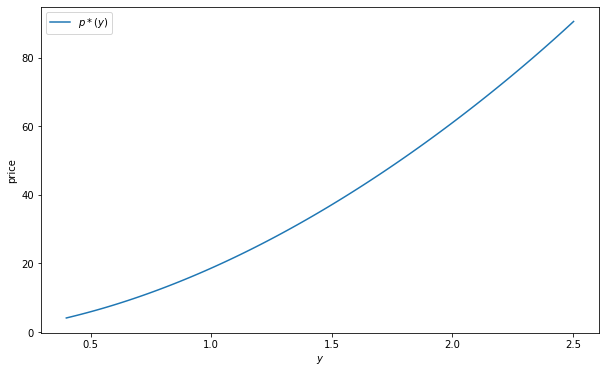

In [6]:
tree = LucasTree()
price_vals = solve_model(tree)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tree.grid, price_vals, label='$p*(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('price')
ax.legend()
plt.show()

We see that the price is increasing, even if we remove all serial correlation from the endowment process.

The reason is that a larger current endowment reduces current marginal
utility.

The price must therefore rise to induce the household to consume the entire endowment (and hence satisfy the resource constraint).

What happens with a more patient consumer?

Here the orange line corresponds to the previous parameters and the green line is price when $\beta = 0.98$.

(mass_lt_cb)=
```{figure} /_static/lecture_specific/lucas_model/solution_mass_ex2.png

```

We see that when consumers are more patient the asset becomes more valuable, and the price of the Lucas tree shifts up.

Exercise 1 asks you to replicate this figure.

## Exercises

(lucas_asset_ex1)=
```{exercise-start}
:label: lucas_ex1
```

Replicate {ref}`the figure <mass_lt_cb>` to show how discount factors affect prices.

```{exercise-end}
```

```{solution-start} lucas_ex1
:class: dropdown
```

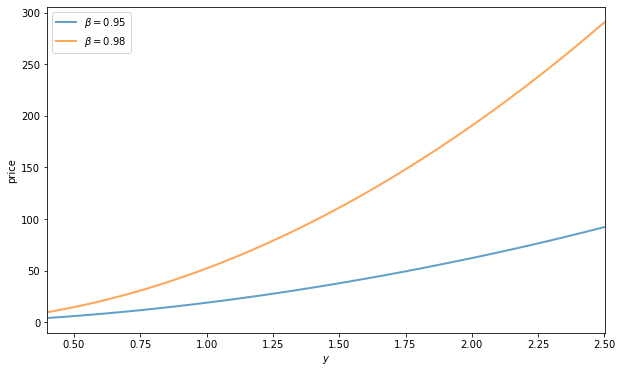

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for β in (.95, 0.98):
    tree = LucasTree(β=β)
    grid = tree.grid
    price_vals = solve_model(tree)
    label = rf'$\beta = {β}$'
    ax.plot(grid, price_vals, lw=2, alpha=0.7, label=label)

ax.legend(loc='upper left')
ax.set(xlabel='$y$', ylabel='price', xlim=(min(grid), max(grid)))
plt.show()

```{solution-end}
```